In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def compute_statistics(peak_list, group, friedel):
    merged = nsx.MergedData(group, friedel)
    for peak in peaks:
        if peak.isSelected():
            merged.addPeak(nsx.PeakCalc(peak))
            
    r = nsx.RFactor()
    cc = nsx.CC()
    
    r.calculate(merged)
    cc.calculate(merged)
    
    stats = {}
    stats['CChalf'] = cc.CChalf()
    stats['CCtrue'] = cc.CCstar()
    stats['Rmeas'] = r.Rmeas()
    stats['Rmerge'] = r.Rmerge()
    stats['Rpim'] = r.Rpim()
    
    return stats

def predict_peaks(data):
    return
    predictor = nsx.PeakPredictor()
    predictor._dmin = 2.1
    predictor._dmax = 50.0
    predictor._searchRadius = 100.0
    predictor._peakScale = 1.0
    predictor._bkgScale = 3.0
    predictor._handler = nsx.ProgressHandler()
    predictor.addPredictedPeaks(data)
    
def num_selected_peaks(peaks):
    num_selected = 0
    
    for peak in peaks:
        if peak.isSelected():
            num_selected += 1
            
    return num_selected
    
def filter_peaks(peaks):
    for peak in peaks:
        if not peak.isSelected():
            continue
            
        if peak.pValue() > 1e-3:
            peak.setSelected(False)
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ())
        
        if d > 50.0 or d < 2.1:
            peak.setSelected(False)
            continue
            
        profile = nsx.Profile()
        
        if profile.fit(peak.getIntegration().getProjectionPeak()) == False:
            peak.setSelected(False)
            continue
        
def remove_deselected(data):
    peaks = data.getPeaks()
    
    for peak in peaks:
        if not peak.isSelected():
            data.removePeak(peak)

In [3]:
expt = nsx.Experiment('test', 'BioDiff2500')
biodiff = expt.getDiffractometer()
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202_new.hdf", biodiff)
data = nsx.DataSet(reader, biodiff)
expt.addData(data)

In [4]:
print(data.getDiffractometer().getSample().getGonio().getNAxes())
print(data.getDiffractometer().getSample().getGonio().getNPhysicalAxes())

6
6


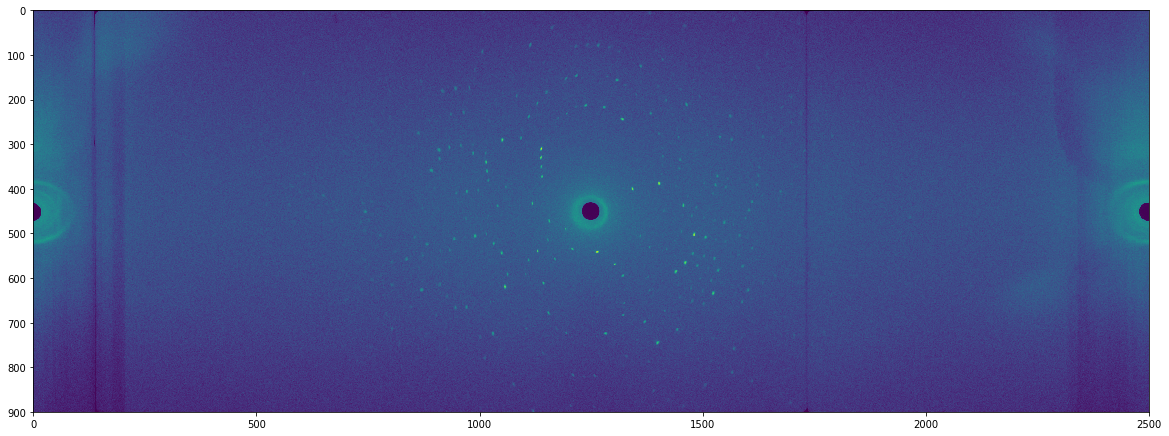

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(np.log(data.getFrame(0)))
plt.show()

In [6]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [7]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setSearchConfidence(0.67)
finder.setIntegrationConfidence(0.98)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [8]:
numors = nsx.vector_data()
numors.push_back(data)
peaks = finder.find(numors)

In [9]:
I = 0.0
I2 = 0.0

for peak in peaks:
    intensity = peak.getCorrectedIntensity().value()
    I += intensity
    I2 += intensity**2
    
I /= peaks.size()

variance = (I2 - peaks.size()*I*I) / (peaks.size()-1)
std = math.sqrt(variance)

print("average intensity =", I)
print("std intensity     =", std)

average intensity = 213955.63116632262
std intensity     = 208422.25532979282


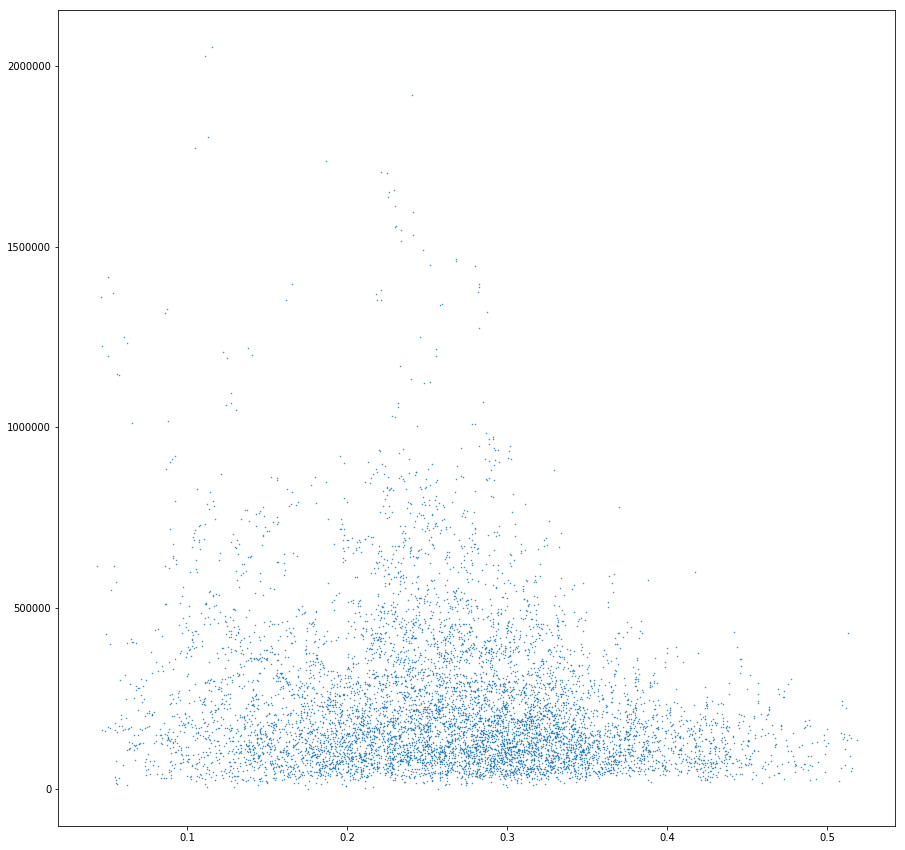

In [10]:
I = []
q = []
good_peaks = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    
    if d < 1.7 or d > 50.0:
        continue
    
    I.append(peak.getCorrectedIntensity().value())
    q.append(np.linalg.norm(peak.getQ().rowVector()))
    good_peaks.append(peak)

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()

In [ ]:
5

In [11]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())
num_to_index = 0

for peak in good_peaks:
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = biodiff.getSample()
sample.addUnitCell(uc)

for peak in peaks:
    peak.addUnitCell(uc, True)


indexing 8263 peaks


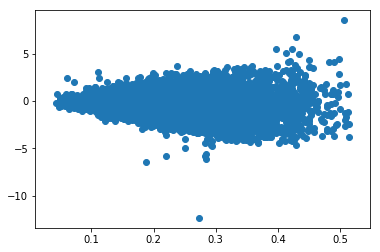

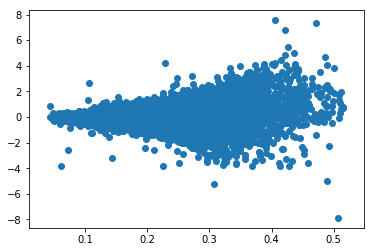

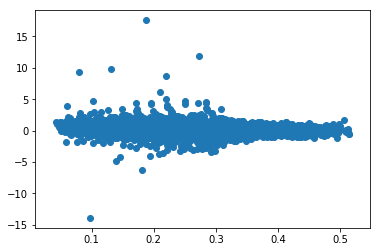

In [25]:
frames = []
q = []
dx = []
dy = []
dz = []
dn = []

better_peaks = []

predictor = nsx.PeakPredictor(data)

for peak in good_peaks:    
    hkl = np.array([[0., 0., 0.]])
    center = peak.getShape().center()
  
    if not uc.getMillerIndices(peak.getQ(), hkl):
        continue   

    hkls = nsx.vectorRowVector3d(1, hkl)    
    preds = predictor.predictPeaks(hkls, uc.reciprocalBasis())
    
    if len(preds) != 1:
        continue
        
    pred_center = preds[0].getShape().center()    
    dd = pred_center - center
    
    d = np.linalg.norm(dd)
    
    if d > 20.0:
        continue
    
    dx.append(dd[0])
    dy.append(dd[1])
    dz.append(dd[2])
    dn.append(d)
    q.append(np.linalg.norm(peak.getQ().rowVector()))
    frames.append(center[2])
    
    if d < 5.0:
        better_peaks.append(peak)
    
plt.scatter(q, dx)
plt.show()

plt.scatter(q, dy)
plt.show()

plt.scatter(q, dz)
plt.show()

#plt.scatter(frames, dn)
#plt.show()


In [ ]:
print(data.getDiffractometer().getSample().getGonio().getNAxes())
print(data.getDiffractometer().getSample().getGonio().getNPhysicalAxes())

In [21]:
refiner = nsx.Refiner(uc, better_peaks, 1)

refiner.refineB()

if not refiner.refine():
    print("failed to refine UB")
    


In [35]:
refiner = nsx.Refiner(uc, better_peaks, 30)

refiner.refineB()

for i in range(6):
    refiner.refineSampleState(data.getInstrumentStates(), i)

if not refiner.refine():
    print("failed to refine UB")
    
batches = refiner.batches()

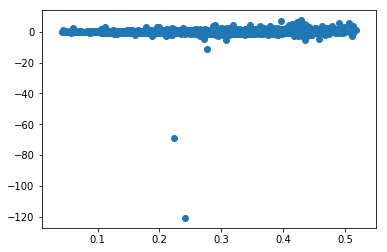

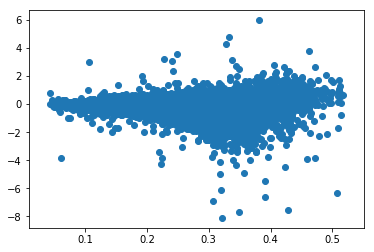

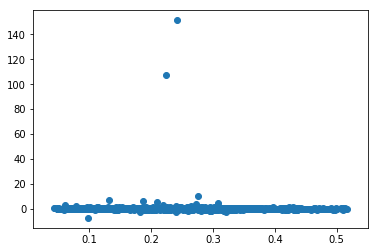

In [40]:
frames = []
q = []
dx = []
dy = []
dz = []
dn = []

better_peaks = []

predictor = nsx.PeakPredictor(data)

for peak in good_peaks:    
    hkl = np.array([[0., 0., 0.]])
    center = peak.getShape().center()
    
    idx = -1
    
    for i in range(len(batches)):
        if batches[i].contains(center[2,0]):
            idx = i
            
    if idx == -1:
        continue    
  
    if not batches[i].cell().getMillerIndices(peak.getQ(), hkl):
        continue   

    hkls = nsx.vectorRowVector3d(1, hkl)    
    preds = predictor.predictPeaks(hkls, batches[idx].cell().reciprocalBasis())
    
    if len(preds) != 1:
        continue
        
    pred_center = preds[0].getShape().center()    
    dd = pred_center - center
    
    d = np.linalg.norm(dd)
    
    if d > 10000.0:
        continue
    
    dx.append(dd[0])
    dy.append(dd[1])
    dz.append(dd[2])
    dn.append(d)
    q.append(np.linalg.norm(peak.getQ().rowVector()))
    frames.append(center[2])
    
    if d < 5.0:
        better_peaks.append(peak)
    
plt.scatter(q, dx)
plt.show()

plt.scatter(q, dy)
plt.show()

plt.scatter(q, dz)
plt.show()



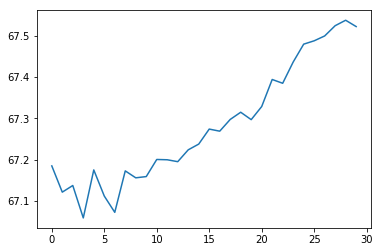

In [44]:
blah = [ b.cell().character().c for b in batches]
plt.plot(blah)
plt.show()


In [ ]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())
num_to_index = 0

for peak in better_peaks:
    d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

In [ ]:
soln[0].basis()
uc.setReciprocalBasis(soln[0].reciprocalBasis())

In [ ]:
I = []
q = []

for peak in better_peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().value())
    q.append(np.linalg.norm(peak.getQ().rowVector()))

plt.figure(figsize=(7,7))
plt.scatter(q, I, s=0.2)
plt.show()

In [ ]:
peaks = data.getPeaks()


# apply some cutoffs to the peaks
for peak in peaks:
    if peak.isSelected() != True:
        continue
    if peak.pValue() > 0.001:
        peak.setSelected(False)
        continue


P = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    P.append(peak.pValue())
    q.append(np.linalg.norm(peak.getQ()))
    
print(len(P), "peaks")

plt.figure(figsize=(15,15))
plt.scatter(q, P, s=0.2)
plt.show()

In [ ]:
# apply some cutoffs to the peaks
num_peaks = 0
for peak in peaks:
    if peak.isSelected() != True:
        continue
        
    prof = nsx.Profile()
    if prof.fit(peak.getIntegration().getProjectionPeak()) == False:
        peak.setSelected(False)
        continue
        
    num_peaks += 1

print(num_peaks)

In [ ]:
n = 3001

peak = peaks[n]
prof = peak.getProfile()

zs = peak.getIntegration().getProjectionPeak().transpose()[0]
qs = [ z for z in zs]
xs = [x for x in range(len(qs))]

print(xs)
print(zs)

ws = np.linspace(xs[0], xs[-1:])

if not prof.fit(zs,1000):
    print("PROFILE FIT FAILED")
    
ys = [prof.evaluate(w) for w in ws ]

plt.plot(ws, ys)
plt.show()

plt.scatter(xs, qs)
plt.show()

calc = [prof.evaluate(x) for x in xs]

print("obs:  ", peak.getRawIntensity().getValue())
print("calc: ", sum(calc))
print("sum:  ", sum(qs))

In [ ]:
help(nsx.PeakIntegrator)

In [ ]:
[1,2,3,4][-1:]

In [ ]:
nsx.PeakCalc(peaks[0])

In [ ]:
compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
high_q_peaks = []

for peak in peaks:
    if peak.isSelected() == False:
        continue
    if 1.0 / np.linalg.norm(peak.getQ()) < 2.1:
        high_q_peaks.append(peak)
        
print(len(high_q_peaks))
print(compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True))

In [ ]:
for i in range(1):
    print('------------------------------------------')
    print(num_selected_peaks(data.getPeaks()))
    filter_peaks(data.getPeaks())
    remove_deselected(data)
    print(num_selected_peaks(data.getPeaks()))
    predict_peaks(data)
    print(num_selected_peaks(data.getPeaks()))
    print(compute_statistics(data.getPeaks(), nsx.SpaceGroup("P 21 21 21"), True))

In [ ]:
dmin = 2.1
dmax = 48.0

good_peaks = []
all_peaks = data.getPeaks()
filter_peaks(all_peaks)

for peak in all_peaks:
    if not peak.isSelected():
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ())
    if d >= dmin and d <= dmax:
        good_peaks.append(peak)
          
print(len(all_peaks))
print(len(good_peaks))

compute_statistics(good_peaks, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
merged = nsx.MergedData(nsx.SpaceGroup("P 21 21 21"), True)

for peak in good_peaks:
    if peak.isSelected():
        merged.addPeak(nsx.PeakCalc(peak))
        
p = []
q = []
        
for peak in merged.getPeaks():
    p.append(peak.chi2()) 
    [[h, k, l]] = peak.getIndex()
    q.append(1.0 / uc.getD(int(h),int(k),int(l)))
        
    
plt.figure(figsize=(15,15))
plt.scatter(q, p, s=0.2)
plt.show()

In [ ]:
peak = merged.getPeaks()[1]
raw_peaks = peak.getPeaks()

In [ ]:
print(raw_peaks)
print(type(raw_peaks))

In [ ]:
help(nsx.PeakCalc)

In [ ]:
help(uc)

In [ ]:
peak.getIndex()

In [ ]:
peaks = data.getPeaks()
qs = []

for peak in peaks:
    qs.append(peak.getQ()[0])
    
xs = [ q[0] for q in qs ]
ys = [ q[1] for q in qs ]
zs = [ q[2] for q in qs ]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, s=0.1)
plt.show()
      

In [ ]:
hs = []
ks = []
ls = []
error = []
frame = []

the_peaks = [peaks[0]]

for peak in peaks:
    if not peak.isSelected():
        continue
    
    center = peak.getShape().getAABBCenter().transpose()[0]
    
    q = peak.getQ()
    hkl = peak.getMillerIndices()[0]
    
    uc = peak.getActiveUnitCell()
    g = uc.getMetricTensor()
    
    real_hkl = uc.fromReciprocalStandard(q)[0]
    
    d = real_hkl-hkl
    
    if (np.linalg.norm(d) > 0.5):
        continue
    
    #print(hkl)
    #print(real_hkl)
    
    hs.append(d[0])
    ks.append(d[1])
    ls.append(d[2])
    error.append(np.linalg.norm(d))
    frame.append(center[2])

In [ ]:
plt.figure(figsize=(15,15))
#plt.scatter(frame, hs, s=0.5, color='r')
#plt.scatter(frame, ks, s=0.5, color='g')
#plt.scatter(frame, ls, s=0.5, color='b')
plt.scatter(frame, error, s=0.5, color='b')
plt.show()